In [2]:
import pandas as pd
import numpy as np
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Initial processing and helper functions

In [3]:
PATH = Path('data/PASCAL_VOC/')
# list(PATH.iterdir())

train_json = json.load((PATH/'pascal_train2007.json').open())
train_json.keys()

IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
train_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

In [4]:
train_json[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [5]:
train_json[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

In [6]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {cat[ID]:cat['name'] for cat in train_json[CATEGORIES]}
train_file_name = {im[ID]:im[FILE_NAME] for im in train_json[IMAGES]}
train_ids = [im[ID] for im in train_json[IMAGES]]

list((PATH/'VOCdevkit'/'VOC2007').iterdir())
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
print(list(IMG_PATH.iterdir())[:5])
img0 = train_json[IMAGES][15]
img0[FILE_NAME], img0[ID], img0['height'], img0['width']

[PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007594.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/005866.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007013.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/005682.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/000080.jpg')]


('000066.jpg', 66, 375, 500)

In [7]:
[{ann[IMG_ID]:[ann[BBOX]]} for ann in train_json[ANNOTATIONS] if ann[IMG_ID]==47][0]

{47: [[14, 0, 445, 312]]}

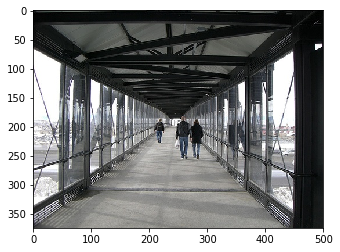

In [8]:
plt.imshow(open_image(IMG_PATH/img0[FILE_NAME]))

In [9]:
def top_left_bottom_right(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_original(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])


In [10]:
train_anno = collections.defaultdict(lambda:[])
for ann in train_json[ANNOTATIONS]:
    if not ann['ignore']:
        bb = ann[BBOX]
        bb = top_left_bottom_right(bb)
        train_anno[ann[IMG_ID]].append((bb, ann[CAT_ID]))

print(len(train_anno))
train_anno[img0[ID]]      

2501


[(array([186, 208, 229, 227]), 15),
 (array([181, 241, 258, 273]), 15),
 (array([187, 268, 258, 294]), 15)]

In [11]:
im = open_image(IMG_PATH/img0[FILE_NAME])

In [12]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [13]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_original(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = train_anno[i]
    im = open_image(IMG_PATH/train_file_name[i])
    print(im.shape)
    draw_im(im, im_a)

### Multiple Classes

In [14]:
MC_CSV = PATH/'tmp/mc.csv'

In [22]:
train_anno[66]

[(array([186, 208, 229, 227]), 15),
 (array([181, 241, 258, 273]), 15),
 (array([187, 268, 258, 294]), 15)]

In [31]:
mc = [set([cats[j[1]] for j in train_anno[i]]) for i in train_ids]
mcs = [' '.join(str(j) for j in m) for m in mc]
mcs[0:5]

['car', 'horse person', 'person bicycle', 'car', 'aeroplane person']

In [34]:
df = pd.DataFrame({'filename': [train_file_name[ti] for ti in train_ids], 'classes': mcs}, columns=['filename','classes'])
df.to_csv(MC_CSV, index=False)

In [35]:
df.head()

,filename,classes
0,000012.jpg,car
1,000017.jpg,horse person
2,000023.jpg,person bicycle
3,000026.jpg,car
4,000032.jpg,aeroplane person


### Class detection

In [36]:
f_model = resnet34
sz = 224
bs = 66

In [37]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

In [38]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [41]:
lrf=learn.lr_find(1e-5,10)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.053389   19.299472  0.3015    



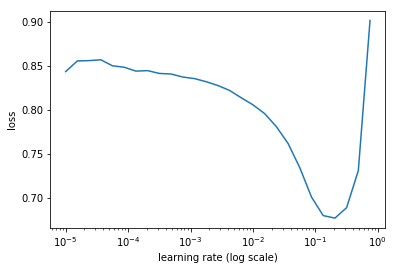

In [42]:
learn.sched.plot(0)

In [43]:
lr = 2e-2

In [45]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.33009    0.131438   0.9579    
    1      0.175413   0.082677   0.972                     
    2      0.117544   0.077636   0.9744                    



[array([0.07764]), 0.9744000043869019]

In [46]:
lrs = np.array([lr/100, lr/10, lr])

In [47]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:17<00:03,  1.56it/s, loss=0.697] 

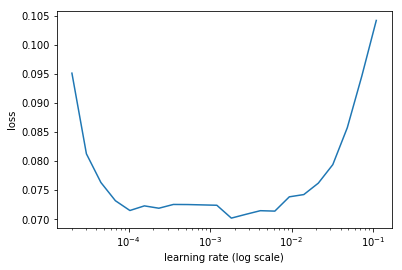

In [48]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [49]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  9%|▉         | 3/32 [00:03<00:30,  1.06s/it, loss=0.0814]


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>                   
    0      0.072422   0.082052   0.9742    
    1      0.054322   0.075908   0.9757                     
    2      0.038964   0.076265   0.9764                     
    3      0.02673    0.077672   0.9769                     
    4      0.019232   0.07837    0.9772                     



[array([0.07837]), 0.9772000069618225]

In [50]:
learn.save('mclas')
learn.load('mclas')

In [51]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

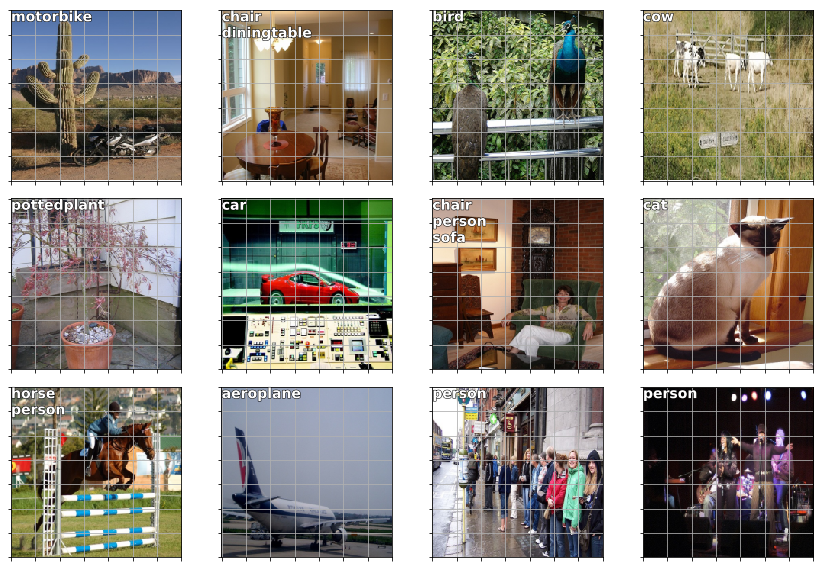

In [56]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i+6]
    ya = np.nonzero(y[i+6]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()